# Data Import
* from *MyDB* on SciServer
* from local

## SciServer

### Authentication

In [1]:
from SciServer import CasJobs     # Communicate between SciServer Compute and CasJobs
from SciServer import Authentication
import os
import dotenv
dotenv_loaded = dotenv.load_dotenv(override=True)

if dotenv_loaded:
    print('Get login name and password from env')
    loginName = os.getenv("SciServerUsername")
    loginPassword = os.getenv("SciServerPassword")
    
    autotoken = Authentication.login(loginName, loginPassword) #Authentication.getToken()
    autotokenvalue = Authentication.token.value
    print(autotoken)
    
    if (autotoken):
        print("Manual login (providing login and password in notebook) successful!")
        print("Login token (via manual login): {0:}".format(autotoken))
    else:
        print("ERROR: Manual login failed. Please check your commands and try again.")
        print("For help, type:")
        print("help(Authentication)")
    
    #user = Authentication.getKeystoneUserWithToken(autotoken)
    #print("userName: {0:}".format(user.userName))
    #print("id: {0:}".format(user.id))
    
    #iden = Authentication.identArgIdentifier()
    #print("ident: {0:}".format(iden))
else:
    print('dotenv not founded')

Get login name and password from env
dc75de0f101d43e091370b4e8b085237
Manual login (providing login and password in notebook) successful!
Login token (via manual login): dc75de0f101d43e091370b4e8b085237


In [2]:
def jobDescriber(jobDescription):
    # Prints the results of the CasJobs job status functions in a human-readable manner
    # Input: the python dictionary returned by getJobStatus(jobId) or waitForJob(jobId)
    # Output: prints the dictionary to screen with readable formatting
    import pandas
    
    if (jobDescription["Status"] == 0):
        status_word = 'Ready'
    elif (jobDescription["Status"] == 1):
        status_word = 'Started'
    elif (jobDescription["Status"] == 2):
        status_word = 'Cancelling'
    elif (jobDescription["Status"] == 3):
        status_word = 'Cancelled'
    elif (jobDescription["Status"] == 4):
        status_word = 'Failed'
    elif (jobDescription["Status"] == 5):
        status_word = 'Finished'
    else:
        status_word = 'Status not found!!!!!!!!!'

    print('JobID: ', jobDescription['JobID'])
    print('Status: ', status_word, ' (', jobDescription["Status"],')')
    print('Target (context being searched): ', jobDescription['Target'])
    print('Message: ', jobDescription['Message'])
    print('Created_Table: ', jobDescription['Created_Table'])
    print('Rows: ', jobDescription['Rows'])
    wait = pandas.to_datetime(jobDescription['TimeStart']) - pandas.to_datetime(jobDescription['TimeSubmit'])
    duration = pandas.to_datetime(jobDescription['TimeEnd']) - pandas.to_datetime(jobDescription['TimeStart'])
    print('Wait time: ',wait.seconds,' seconds')
    print('Query duration: ',duration.seconds, 'seconds')

### Data Request

In [3]:
table_name = "DR17_table"
table_size = 4618753  # max avaiable data for DR17_table

#### Table drop

In [4]:
CasJobs.executeQuery(sql=f"""DROP TABLE {table_name}""", context="MyDB")

,Rows Affected
0,0


#### Query for request new table to store in MyDB

In [5]:
main_query = f"""
SELECT TOP {table_size}
    p.ra AS ra, 
    p.dec AS dec, 
    p.u AS u, 
    p.g AS g, 
    p.r AS r, 
    p.i AS i, 
    p.z AS z, 
    s.z AS redshift, 
    s.class AS class
INTO mydb.{table_name}
FROM 
    PhotoObj AS p 
JOIN 
    SpecObj AS s 
    ON s.bestobjid = p.objid
WHERE 
    p.ra BETWEEN 0 AND 360 AND p.dec BETWEEN -90 AND 90
ORDER BY NEWID()
"""
# ORDER BY NEWID() Randomizza le righe
import warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  jobid = CasJobs.submitJob(sql=main_query, context="DR17")

print(f'\nJob submitted with jobId: {jobid} for table: {table_name} and size: {table_size}')

waited = CasJobs.waitForJob(jobId=jobid)     
jobDescription = CasJobs.getJobStatus(jobid)

print('\nInformation about the job:')

jobDescriber(jobDescription)

tables = CasJobs.getTables(context="MyDB") 
print('Tables in :\n',tables)


Job submitted with jobId: 76867273 for table: DR17_table and size: 4618753

Information about the job:
JobID:  76867273
Status:  Finished  ( 5 )
Target (context being searched):  DR17
Message:  Query Complete
Created_Table:  DR17_table
Rows:  4618753
Wait time:  2  seconds
Query duration:  138 seconds
Tables in :
 [{'Name': 'DR17_table', 'Rows': 4618753, 'Size': 270280, 'Date': 638770001418000000}]


### Download table from MyDB

In [14]:
# datasets can be very big, flag must be set True manually
# to avoid new download on kernel restart.
# "DR17_table" with table_size = 4618753 is approx 423 MB
MyDB_download = False 

if MyDB_download:
    df = CasJobs.getPandasDataFrameFromQuery(f"""SELECT * FROM {table_name}""", context="MyDB")

In [7]:
# save table to local csv
df.to_csv(f"{table_name}.csv", index=False)

## Local table load

In [8]:
import pandas as pd

df = pd.read_csv('DR17_table.csv', nrows=10000)

# Dataset Preprocessing

#### Import

In [9]:
# Standard Python modules
import os
import time

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PyTorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

# TorchMetrics (avoiding redundant imports)
import torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics.regression import MeanSquaredError as MSE, MeanAbsoluteError as MAE

# CUDA device check
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

print(f"Computation device: {device}\n")

Computation device: cuda



## Preprocessing

In [10]:
print("dataframe shape:",df.shape)

# print sample number for each class (GALAXY, STAR, Q (QUASAR))
display(df['class'].value_counts().to_frame().style.bar(color='green'))

# -9999 values are outliers
display(df.iloc[:,2:].describe())

dataframe shape: (10000, 9)


,count
class,
GALAXY,6037
QSO,1984
STAR,1979


,u,g,r,i,z,redshift
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,22.101797,20.642059,19.654663,19.086895,18.766882,0.595812
std,2.277094,2.045252,1.868607,1.768339,1.774664,0.743184
min,14.428930,12.873990,11.894320,11.516480,11.935390,-0.004021
25%,20.340895,18.989280,18.140995,17.759180,17.473498,0.071827
50%,22.200580,21.126665,20.161995,19.424820,19.016955,0.450031
75%,23.745908,22.137322,21.045068,20.405323,19.924485,0.715440
max,28.436950,27.405460,27.952560,26.401330,26.058610,7.011245


### Outlier removal, label encoding, class weight and normalization

In [11]:
# outlier
for col in df:
  df = df[ df[col] != -9999.0]

label_col = 'class'

cls_w = {}
cls_dict = {}
cls_count = df.shape[0]

i_cls = 0
for cls in df[label_col].unique():
    cls_dict.update( { i_cls : cls } )
    
    # class weight
    cls_w.update(dict( { cls : (1 - (df[ df['class'] == cls ].shape[0] / cls_count)) } ))
    print(f'weight for { cls }: \t{ "{:1.5f}".format(cls_w[cls]) }')

    # label encoding
    df.loc[ df.loc[:, label_col] == cls, label_col ] = i_cls
    i_cls += 1    
    
df[label_col] = df[label_col].astype('int8')

# Normalization
df.iloc[:,:-1] = (df.iloc[:,:-1] - df.iloc[:,:-1].min())/(df.iloc[:,:-1].max() - df.iloc[:,:-1].min())

display(df)

weight for GALAXY: 	0.39630
weight for QSO: 	0.80160
weight for STAR: 	0.80210


,ra,dec,u,g,r,i,z,redshift,class
0,0.622124,0.367323,0.820060,0.585326,0.487519,0.484330,0.438882,0.072143,0
1,0.618156,0.566804,0.591318,0.577454,0.513266,0.522191,0.489267,0.078819,0
2,0.575919,0.661994,0.467743,0.551389,0.552554,0.603231,0.608249,0.236160,1
3,0.340032,0.541985,0.688787,0.715571,0.615701,0.585371,0.566439,0.098677,0
4,0.925795,0.398078,0.646328,0.750473,0.632305,0.616493,0.564183,0.111515,0
...,...,...,...,...,...,...,...,...,...
9995,0.349356,0.611364,0.718143,0.609397,0.501201,0.514316,0.478870,0.060053,0
9996,0.655572,0.525752,0.376371,0.463811,0.456574,0.516028,0.525559,0.177822,1
9997,0.451806,0.268524,0.426050,0.394162,0.363923,0.391727,0.360414,0.013024,0
9998,0.393483,0.433163,0.636889,0.613438,0.559081,0.570219,0.534356,0.089793,0


## Dimensionality Reduction

#### PCA

Explained variance comp. 1 -> 0.7631007872191913
Explained variance comp. 2 -> 0.1510188734446272
Explained variance comp. 3 -> 0.06358083975049383
Sum of explained varianca for 3 components -> 0.9777005004143122


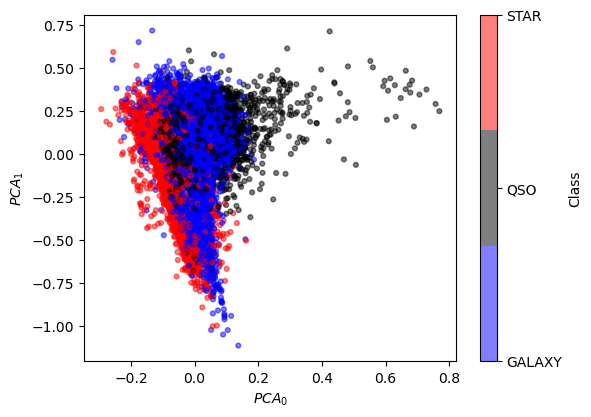

In [17]:
pca = PCA(3) # 3 for 3d plot
x_cls_pca = pca.fit_transform(df.drop(columns=[ 'ra', 'dec', label_col]))
pca_var = pca.explained_variance_ratio_

for i in range(0, len(pca_var)):
    print(f"Explained variance comp. {i+1} -> {pca_var[i]}")
print(f"Sum of explained varianca for {i+1} components -> {pca_var.sum()}")

plot_limit = 50000
cmap = colors.ListedColormap(['blue', 'black', 'red'], name = 'class')
                            
plt.figure(figsize=(6, 4.5))
sc1 = plt.scatter(x_cls_pca[:plot_limit,2], x_cls_pca[:plot_limit,0], c=df.iloc[:plot_limit, -1], cmap=cmap, alpha=0.5, s=12)
cbar = plt.colorbar(sc1, label='Class')
cbar.set_ticks(list(cls_dict.keys())) 
cbar.set_ticklabels(list(cls_dict.values())) 

plt.xlabel("${PCA}_0$")
plt.ylabel("${PCA}_1$")
plt.show()

#### t-SNE

perplexity:10 - computed
perplexity:20 - computed
perplexity:40 - computed


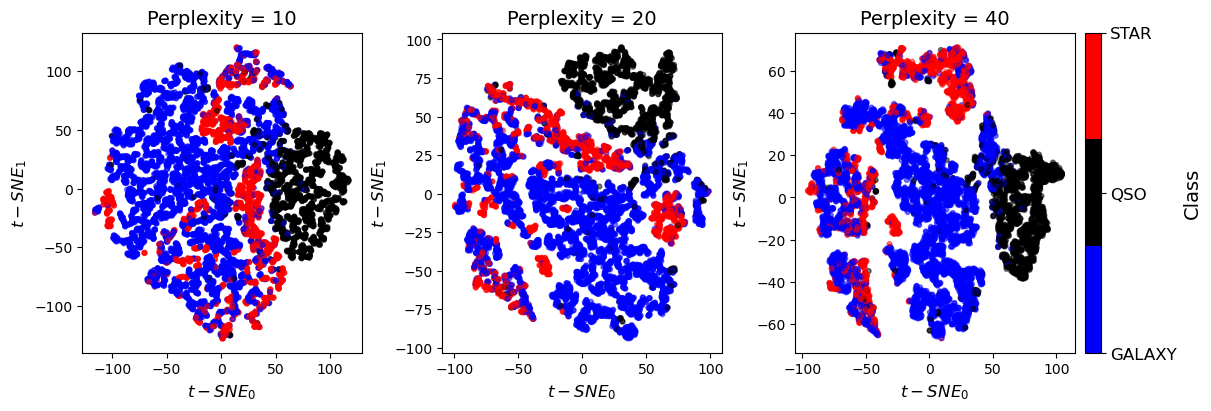

In [18]:
from sklearn.manifold import TSNE

perp = [10, 20, 40]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

for i, (p, ax) in enumerate(zip(perp, axes)):
    X_embedded = TSNE(n_components=2, 
                      learning_rate='auto', 
                      init='random', 
                      perplexity=p).fit_transform(x_cls_pca)
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df[label_col], cmap=cmap, alpha=0.5, s=12)
    ax.set_title(f'Perplexity = {p}', fontsize=14)
    ax.set_xlabel("${t-SNE}_0$", fontsize=12)
    ax.set_ylabel("${t-SNE}_1$", fontsize=12)
    print(f'perplexity:{p} - computed')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(cls_dict.keys()), vmax=max(cls_dict.keys())))
sm.set_array([]) 

cbar = fig.colorbar(sm, ax=axes, location="right", shrink=1, aspect=20, pad=0.01)
cbar.set_ticks(list(cls_dict.keys()))
cbar.set_ticklabels(list(cls_dict.values()), fontsize=12)
cbar.set_label("Class", fontsize=14)
plt.show()

In [ ]:
plot3d_limit = 50000
plot3d_offset = 0
fig = px.scatter_3d(x = x_cls_pca[plot3d_offset:plot3d_limit + plot3d_offset,0], 
                    y = x_cls_pca[plot3d_offset:plot3d_limit + plot3d_offset,1], 
                    z = x_cls_pca[plot3d_offset:plot3d_limit + plot3d_offset,2],
                    color = df.iloc[plot3d_offset:plot3d_limit + plot3d_offset, -1].map(cls_dict),
                    color_discrete_map = { cls_dict[cls] : cmap.colors[cls] for cls in cls_dict})


fig.update_layout(
    autosize=False,
    width=800, 
    height=600,
    margin=dict(l=30,r=30,b=30,t=30,pad=4), 
    scene = dict(xaxis_title='PCA0', yaxis_title='PCA1', zaxis_title='PCA2'),
    paper_bgcolor="white", 
    scene_aspectmode='cube',
    legend_title="Class",
    legend=dict(tracegroupgap=0,  
                itemsizing='constant'
               )
)
fig.update_traces(marker=dict(size=1))
fig.update_layout(
    legend=dict(itemwidth=30,
                tracegroupgap=10
               )
)
fig.show()

## FNN (work in progress)

### Split data

In [ ]:
corr_fact = 0.85
train_size = 0.8
valid_size = 0.5
seed = 42

gal_df = df[ df[ label_col ] == cls_dict['GALAXY'] ]
qso_star_df = df[ (df[ label_col ] == cls_dict['QSO']) | (df[ label_col ] == cls_dict['STAR']) ]

gal_df_train, gal_df_split = train_test_split(gal_df,
                                              train_size = train_size * cls_w['GALAXY'] * corr_fact,
                                              random_state = seed)

qso_star_df_train, qso_star_df_split = train_test_split(qso_star_df,
                                                        train_size = train_size,
                                                        random_state = seed)

df_train = pd.concat( [gal_df_train, qso_star_df_train] )

print("Train size:")
display(df_train[ label_col ].value_counts().to_frame().style.bar(color='green'))

df_split = pd.concat( [gal_df_split, qso_star_df_split] )

df_valid, df_test = train_test_split(df_split, 
                                     train_size = valid_size,
                                     random_state = seed)

print("\nValidation size:")
display(df_valid[ label_col ].value_counts().to_frame().style.bar(color='green'))

print("\nTest size:")
display(df_test[ label_col ].value_counts().to_frame().style.bar(color='green'))

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
import time
t0 = time.time()

rfc_estimators = np.linspace(1, 10, 4, dtype=int)
rfc_depths = np.linspace(10, 60, 6, dtype=int)

vali_score = []
train_score = []
counter=1

for depth in rfc_depths:
  for est in rfc_estimators:
    model = RFC(n_estimators=est, min_samples_leaf=3, criterion='entropy', max_depth=depth)
    model.fit(x_cls_train, y_cls_train)
    train_score.append(model.score(x_cls_train, y_cls_train))
    vali_score.append(model.score(x_cls_vali, y_cls_vali))
    t1=time.time()
    print(f'time: {t1-t0:.2f}s;\titeration num: {counter};\test: {est:2}; depth: {depth:2};\ttrain score: {train_score[-1]:.3f};\tvali score: {vali_score[-1]:.3f}')
    counter+=1
    t0 = time.time()
    

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,len(train_score)+1),train_score, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(vali_score)+1),vali_score, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
del df 
del gal_df_train, gal_df_split
del qso_star_df_train, qso_star_df_split

### Test

In [ ]:
import pandas as pd
import SciServer
from SciServer import CasJobs     
import sklearn.preprocessing as preprocessing
import torch

myquery = """
SELECT TOP 10000
p.ra AS ra, p.dec AS dec, 
p.u AS u, p.g AS g, p.r AS r, p.i AS i, p.z AS z, 
s.z AS redshift, s.class AS class
FROM PhotoObj AS p JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.ra BETWEEN 0 AND 360 AND p.dec BETWEEN -90 AND 90
"""

import warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  test_df = CasJobs.executeQuery(sql=myquery, context="DR17")
display(test_df)

display(test_df['class'].value_counts())
display(test_df['class'].value_counts(normalize=True).to_frame().style.bar(color='green'))

x_cls_test = test_df.drop(['ra', 'dec', 'class'], axis = 1).values
y_cls = test_df['class'].values

LE_test = preprocessing.LabelEncoder()
y_cls_test = LE_test.fit_transform(y_cls)

sc_cls_test = preprocessing.StandardScaler()
x_cls_test = sc_cls_test.fit_transform(x_cls_test)
x_cls_test_pt = torch.tensor(x_cls_test).float()
y_cls_test_pt = torch.tensor(y_cls_test, dtype=torch.uint8)

#ds_cls_test = TensorDataset(x_cls_test_pt, y_cls_test_pt) # a datset are pair of feature Tensor, target Tensor
#dl_cls_test = DataLoader(ds_cls_test, batch_size=10, shuffle=True, num_workers=subproc, drop_last=True, pin_memory=pin_mem) 

In [ ]:
# Uso di un modello addestrato in inferenza (predizione)
from matplotlib import pyplot as plt
# lettura del modello
model_data = torch.load('sloan_classifier.pt')
print('Best model at epoch: ', model_data['epoch'])
model = model_data['model']
model.eval() 
model.to(device)

cls_w_pt = torch.tensor(np.array(cls_w)).float() #to balance classes
cls_w_pt=cls_w_pt.to(device) #move it to device
#loss_fun = nn.CrossEntropyLoss(cls_w_pt)

loss_fun = model_data['loss']
loss_fun.to(device)

metric_fun = model_data['metric']
metric_fun.to(device)

loss = 0
metric = 0
counter = 0

predictions = np.empty(shape=(0,),dtype=int)
truths = np.empty(shape=(0,),dtype=int)

with torch.no_grad(): #evita che vengano cacolati automaticamente i gradienti
  #for xb, yb in dl_cls_test:
  counter += 1
  #xb=xb.to(device)
  #yb=yb.type(torch.LongTensor).to(device)
  
  x_cls_test_pt = x_cls_test_pt.to(device)
  y_cls_test_pt = y_cls_test_pt.to(device)
  
  #pred = model(xb)
  pred = model(x_cls_test_pt)

  loss += loss_fun(pred, y_cls_test_pt).item()
  metric += metric_fun(pred, y_cls_test_pt).item()

  pred = pred.cpu()
  
  y_cls_test_pt = y_cls_test_pt.cpu()
  #yb = yb.cpu()
  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions, res.detach().numpy()))
  #truths = np.concatenate((truths,yb.detach().numpy()))
  truths = np.concatenate((truths, y_cls_test_pt.detach().numpy()))
    
  loss /= counter
  metric /= (counter)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = LE.inverse_transform(predictions)
truths = LE.inverse_transform(truths)

c_mat = confusion_matrix(predictions, truths, normalize='true')
print("Confusion Matrix:")

fig, axs = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=LE.classes_)
disp.plot(ax = axs)
disp.ax_.set_title('Confusion Matrix')
disp.im_.colorbar.remove()
plt.show()
print('Test loss/accuracy: ',loss, ' / ', metric)